In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from networks import DQN
from scipy import stats

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Torch Version: ", torch.__version__)

Device:  cuda
Torch Version:  1.0.1.post2


In [3]:
def increase_capacity_keep_lr(network, capacity, optimizer, device):
    # Store old ids
    old_ids = [id(p) for p in network.parameters()]
    old_param_sizes = [p.size() for p in network.parameters()]

    network.increase_capacity(capacity)

    # Store new ids
    new_ids = [id(p) for p in network.parameters()]
    new_param_sizes = [p.size() for p in network.parameters()]

    # Store old state 
    opt_state_dict = optimizer.state_dict()
    for old_id, new_id, new_param_size, old_param_size in zip(old_ids, new_ids, new_param_sizes, old_param_sizes):
        # Store step, and exp_avgs
        step = opt_state_dict['state'][old_id]['step']
        old_exp_avg = opt_state_dict['state'][old_id]['exp_avg']
        old_exp_avg_sq = opt_state_dict['state'][old_id]['exp_avg_sq']
        old_max_exp_avg_sq = opt_state_dict['state'][old_id]['max_exp_avg_sq']

        exp_avg = torch.zeros(new_param_size)
        exp_avg_sq = torch.zeros(new_param_size)
        max_exp_avg_sq =  torch.zeros(new_param_size)
        # Extend exp_avgs to new shape depending on wether param is bias or weight
        if exp_avg.dim()>1:
            # Weights
            exp_avg[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg_sq
            max_exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_max_exp_avg_sq
        else:
            # Biases/last layer
            exp_avg[0:old_param_size[0]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0]] = old_exp_avg_sq
            max_exp_avg_sq[0:old_param_size[0]] = old_max_exp_avg_sq
        
        # Delete old id from state_dict and update new params and new id
        del opt_state_dict['state'][old_id]
        opt_state_dict['state'][new_id] = {
            'step': step,
            'exp_avg': exp_avg,
            'exp_avg_sq': exp_avg_sq.to(device),
            'max_exp_avg_sq' : max_exp_avg_sq.to(device)
        }
        opt_state_dict['param_groups'][0]['params'].remove(old_id)
        opt_state_dict['param_groups'][0]['params'].append(new_id)

    network.to(device)
    optimizer = optim.Adam(network.parameters(), amsgrad=True)
    optimizer.load_state_dict(opt_state_dict)
    
    return network, optimizer

In [ ]:
def generate_zero():
    return random.uniform(0, 49) / 100

def generate_one():
    return random.uniform(50, 100) / 100

def generate_both(num_data_points, p):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        if random.random() < p:
            c = random.randint(0,3)
            if c==0:
                Xs.append([generate_zero(), generate_zero(), 0]); Ys.append([0])
            elif c==1:
                # or(1, 0) -> 1
                Xs.append([generate_one(), generate_zero(), 0]); Ys.append([1])
            elif c==2:
                # or(0, 1) -> 1
                Xs.append([generate_zero(), generate_one(), 0]); Ys.append([1])
            else:
                # or(1, 1) -> 1
                Xs.append([generate_one(), generate_one(), 0]); Ys.append([1])
        else:
            c = random.randint(0,3)
            if c==0:
                # xor(0, 0) -> 0
                Xs.append([generate_zero(), generate_zero(), 1]); Ys.append([0])
            elif c==1:
                # xor(1, 0) -> 1
                Xs.append([generate_one(), generate_zero(), 1]); Ys.append([1])
            elif c==2:
                # xor(0, 1) -> 1
                Xs.append([generate_zero(), generate_one(), 1]); Ys.append([1])
            else:
                # xor(1, 1) -> 0
                Xs.append([generate_one(), generate_one(), 1]); Ys.append([0])
    return Xs, Ys
# def generate_both(num_data_points, p):
#     Xs, Ys = [], []
#     for _ in range(num_data_points):
#         if random.random() < p:
#             c = random.randint(0,3)
#             if c==0:
#                 Xs.append([0.0, 0.0, 0.0]); Ys.append([0])
#             elif c==1:
#                 # or(1, 0) -> 1
#                 Xs.append([1.0, 0.0, 0.0]); Ys.append([1])
#             elif c==2:
#                 # or(0, 1) -> 1
#                 Xs.append([0.0, 1.0, 0.0]); Ys.append([1])
#             else:
#                 # or(1, 1) -> 1
#                 Xs.append([1.0, 1.0, 0.0]); Ys.append([1])
#         else:
#             c = random.randint(0,3)
#             if c==0:
#                 # xor(0, 0) -> 0
#                 Xs.append([0.0, 0.0, 1.0]); Ys.append([0])
#             elif c==1:
#                 # xor(1, 0) -> 1
#                 Xs.append([1.0, 0.0, 1.0]); Ys.append([1])
#             elif c==2:
#                 # xor(0, 1) -> 1
#                 Xs.append([0.0, 1.0, 1.0]); Ys.append([1])
#             else:
#                 # xor(1, 1) -> 0
#                 Xs.append([1.0, 1.0, 1.0]); Ys.append([0])
#     return Xs, Ys

def generate_or_XY(num_data_points):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        # or(0, 0) -> 0 
        Xs.append([generate_zero(), generate_zero(), 0]); Ys.append([0])
        # or(1, 0) -> 1
        Xs.append([generate_one(), generate_zero(), 0]); Ys.append([1])
        # or(0, 1) -> 1
        Xs.append([generate_zero(), generate_one(), 0]); Ys.append([1])
        # or(1, 1) -> 1
        Xs.append([generate_one(), generate_one(), 0]); Ys.append([1])
    return Xs, Ys

def generate_xor_XY(num_data_points):
    Xs, Ys = [], []
    for _ in range(num_data_points):
        # xor(0, 0) -> 0 
        Xs.append([generate_zero(), generate_zero(), 1]); Ys.append([0])
        # xor(1, 0) -> 1
        Xs.append([generate_one(), generate_zero(), 1]); Ys.append([1])
        # xor(0, 1) -> 1
        Xs.append([generate_zero(), generate_one(), 1]); Ys.append([1])
        # xor(1, 1) -> 0
        Xs.append([generate_one(), generate_one(), 1]); Ys.append([0])
    return Xs, Ys

/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


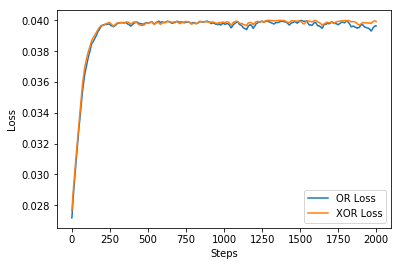

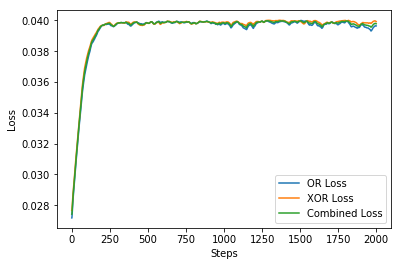

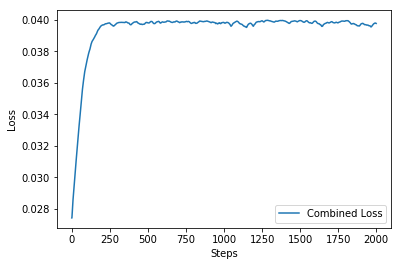

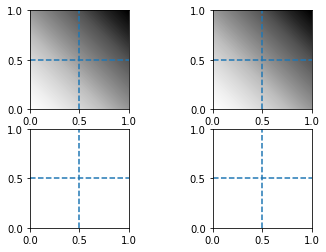

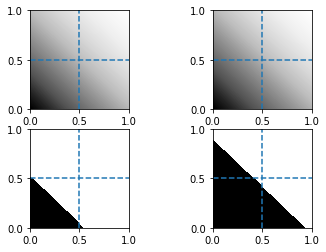

[1] False None
Average loss or before training:  0.5455200880765915
Average loss xor before training:  0.5551641911268235
Average loss before training:  0.5503421396017074
Average loss or before xor training:  0.5455200880765915
Average loss xor before xor training:  0.5551641911268235
Average loss before xor training:  0.5503421396017074
Average loss or:  0.7928173184394837
Average loss xor:  0.7984086751937867
Average loss:  0.7956129968166352
Median loss:  0.7984490334987641
Max loss:  0.8006293714046478
Min loss:  0.7890193998813629
Average change:  0.2452708572149278
[0.8025133311748505, 0.802850067615509, 0.8021765947341919, 3, [1], False, None]


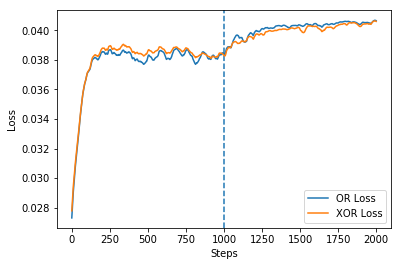

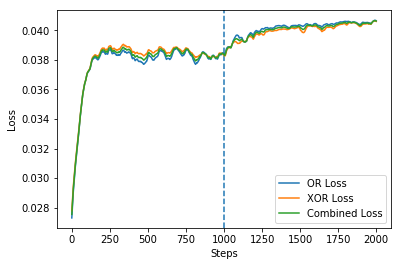

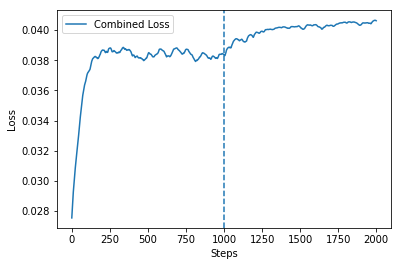

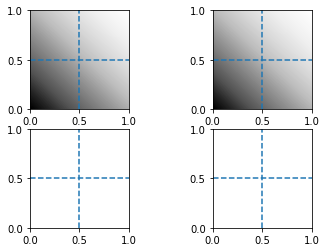

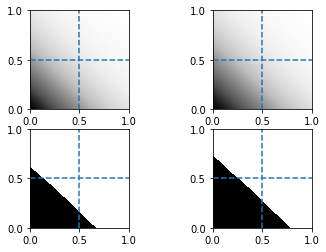

[1] True None
Average loss or before training:  0.5455200880765915
Average loss xor before training:  0.5551641911268235
Average loss before training:  0.5503421396017074
Average loss or before xor training:  0.7686247825622559
Average loss xor before xor training:  0.7662333250045776
Average loss before xor training:  0.7674290537834167
Average loss or:  0.8128281950950622
Average loss xor:  0.811905300617218
Average loss:  0.81236674785614
Median loss:  0.8138093829154969
Max loss:  0.8189300179481507
Min loss:  0.8056538879871369
Average change:  0.0449376940727233
[0.8249521255493164, 0.8259547352790833, 0.8239495158195496, 2, [1], True, None]


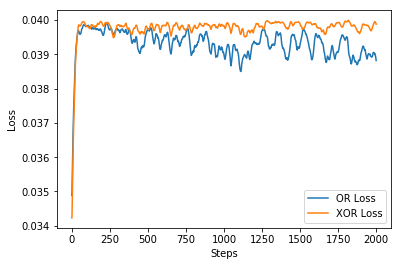

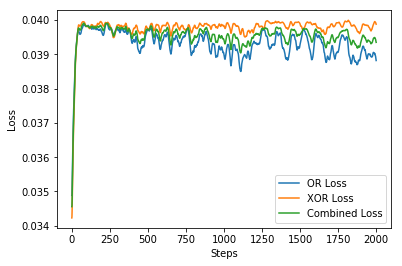

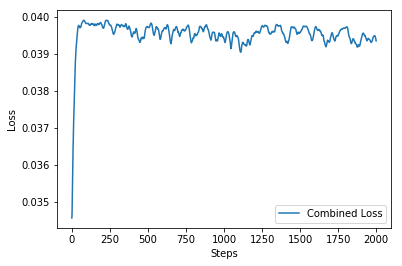

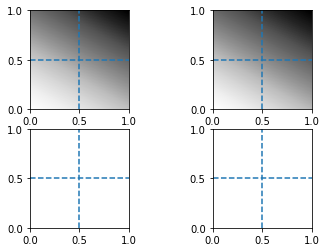

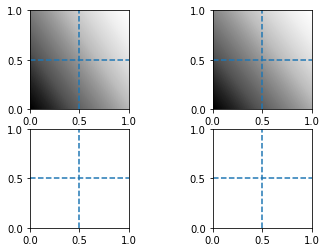

[2] False None
Average loss or before training:  0.6956098437309265
Average loss xor before training:  0.6823360204696656
Average loss before training:  0.688972932100296
Average loss or before xor training:  0.6956098437309265
Average loss xor before xor training:  0.6823360204696656
Average loss before xor training:  0.688972932100296
Average loss or:  0.776390790939331
Average loss xor:  0.7975813865661621
Average loss:  0.7869860887527466
Median loss:  0.7824221909046173
Max loss:  0.7984260678291321
Min loss:  0.7796740293502807
Average change:  0.09801315665245058
[0.7979353964328766, 0.799270749092102, 0.7966000437736511, 0, [2], False, None]


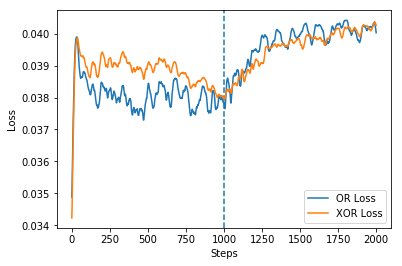

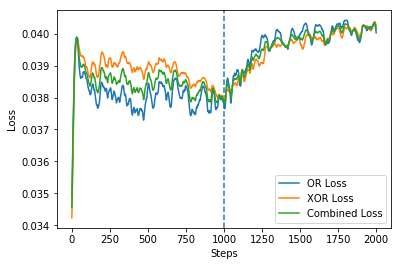

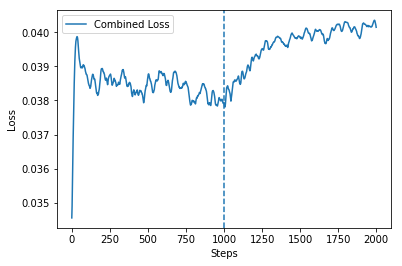

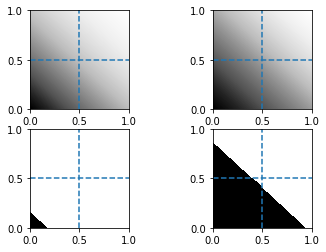

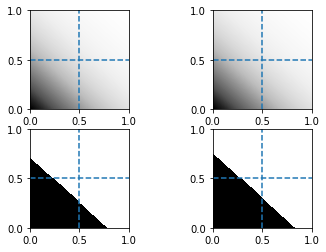

[2] True None
Average loss or before training:  0.6956098437309265
Average loss xor before training:  0.6823360204696656
Average loss before training:  0.688972932100296
Average loss or before xor training:  0.7573045372962952
Average loss xor before xor training:  0.7603026866912842
Average loss before xor training:  0.7588036119937898
Average loss or:  0.8006279230117798
Average loss xor:  0.8051720023155212
Average loss:  0.8028999626636505
Median loss:  0.8079807341098786
Max loss:  0.8161839127540589
Min loss:  0.7806653261184693
Average change:  0.04409635066986073
[0.8263584673404694, 0.8271958231925964, 0.8255211114883423, 2, [2], True, None]


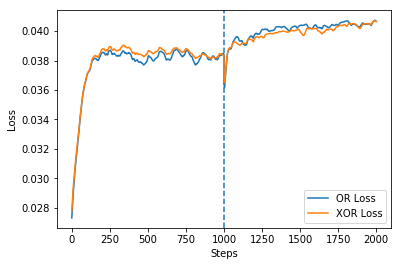

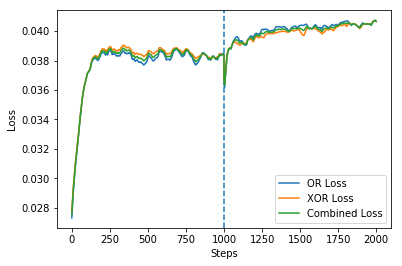

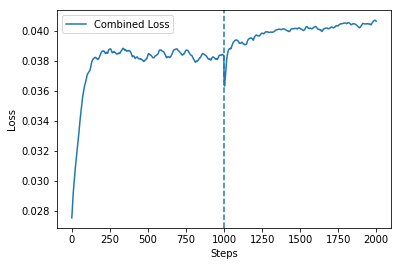

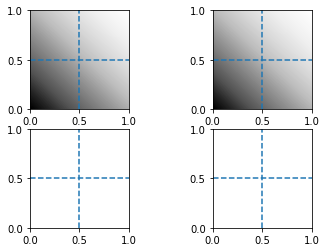

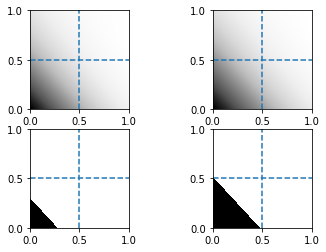

[1] True [1]
Average loss or before training:  0.5455200880765915
Average loss xor before training:  0.5551641911268235
Average loss before training:  0.5503421396017074
Average loss or before xor training:  0.7686247825622559
Average loss xor before xor training:  0.7662333250045776
Average loss before xor training:  0.7674290537834167
Average loss or:  0.8132221341133118
Average loss xor:  0.81294846534729
Average loss:  0.8130852997303009
Median loss:  0.8156128823757172
Max loss:  0.817703366279602
Min loss:  0.8071087300777435
Average change:  0.04565624594688411
[0.8203339874744415, 0.8182772994041443, 0.8223906755447388, 1, [1], True, [1]]


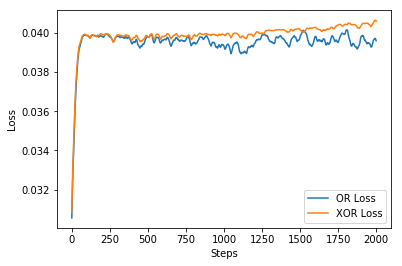

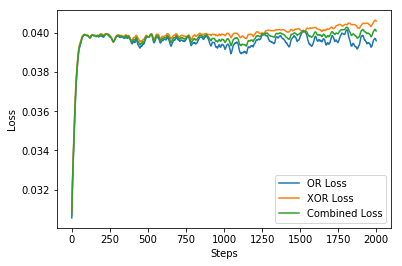

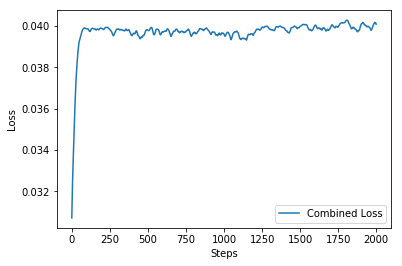

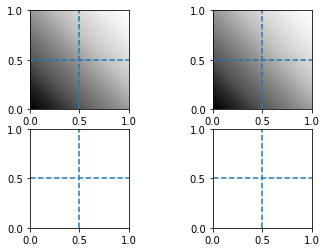

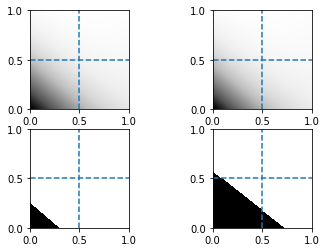

[3] False None
Average loss or before training:  0.6030644595623016
Average loss xor before training:  0.6089354991912842
Average loss before training:  0.605999979376793
Average loss or before xor training:  0.6030644595623016
Average loss xor before xor training:  0.6089354991912842
Average loss before xor training:  0.605999979376793
Average loss or:  0.791824197769165
Average loss xor:  0.8118666291236878
Average loss:  0.8018454134464263
Median loss:  0.8063491523265839
Max loss:  0.8171961843967438
Min loss:  0.7816525042057038
Average change:  0.1958454340696334
[0.8283582925796509, 0.8225257396697998, 0.834190845489502, 4, [3], False, None]


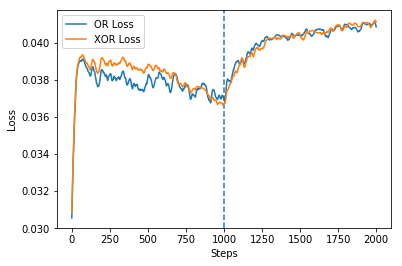

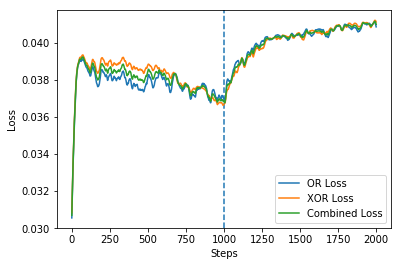

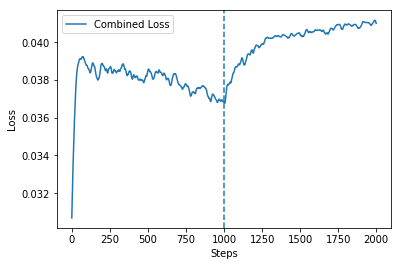

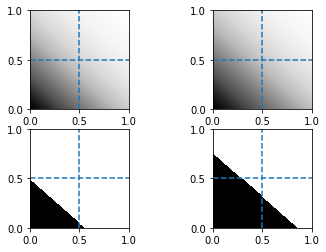

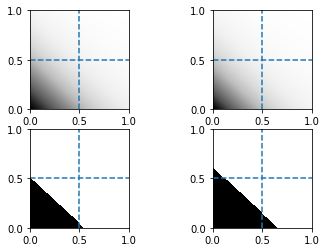

[3] True None
Average loss or before training:  0.6030644595623016
Average loss xor before training:  0.6089354991912842
Average loss before training:  0.605999979376793
Average loss or before xor training:  0.7407933592796325
Average loss xor before xor training:  0.7336804270744324
Average loss before xor training:  0.7372368931770324
Average loss or:  0.8173022031784057
Average loss xor:  0.8226406693458557
Average loss:  0.8199714362621306
Median loss:  0.8200311422348022
Max loss:  0.8276006639003753
Min loss:  0.8076997756958008
Average change:  0.0827345430850982
[0.8351680934429169, 0.8281583189964294, 0.8421778678894043, 4, [3], True, None]


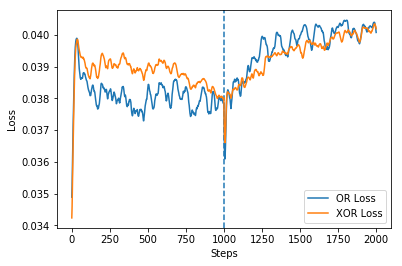

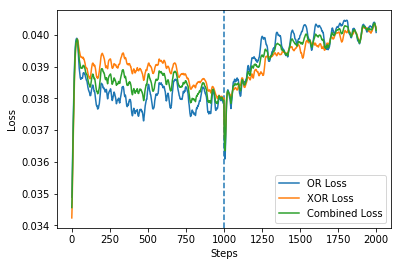

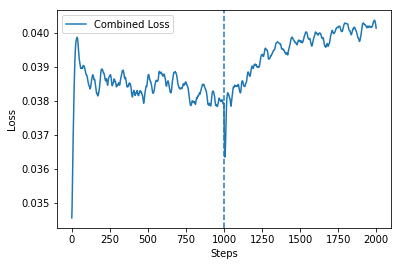

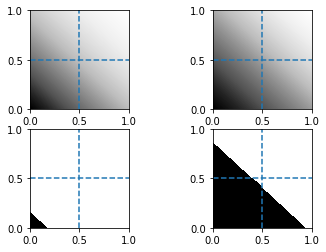

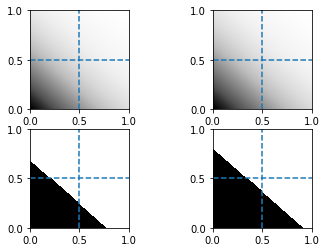

[2] True [1]
Average loss or before training:  0.6956098437309265
Average loss xor before training:  0.6823360204696656
Average loss before training:  0.688972932100296
Average loss or before xor training:  0.7573045372962952
Average loss xor before xor training:  0.7603026866912842
Average loss before xor training:  0.7588036119937898
Average loss or:  0.8016579270362854
Average loss xor:  0.8040523171424866
Average loss:  0.802855122089386
Median loss:  0.8094331741333007
Max loss:  0.8149235665798187
Min loss:  0.7834913253784179
Average change:  0.04405151009559627
[0.823576956987381, 0.8257948160171509, 0.8213590979576111, 2, [2], True, [1]]


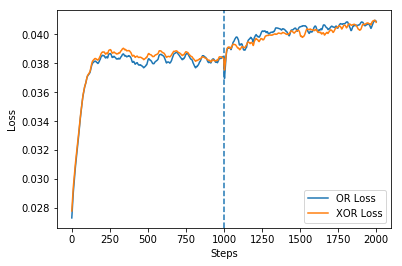

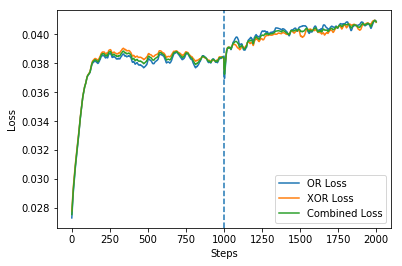

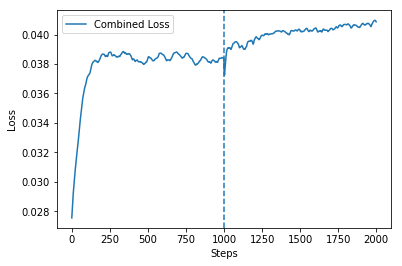

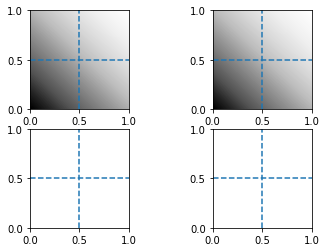

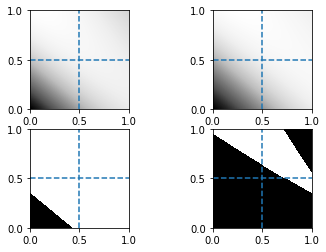

[1] True [2]
Average loss or before training:  0.5455200880765915
Average loss xor before training:  0.5551641911268235
Average loss before training:  0.5503421396017074
Average loss or before xor training:  0.7686247825622559
Average loss xor before xor training:  0.7662333250045776
Average loss before xor training:  0.7674290537834167
Average loss or:  0.8180524349212647
Average loss xor:  0.8167499542236328
Average loss:  0.8174011945724488
Median loss:  0.8159810423851013
Max loss:  0.8303560137748718
Min loss:  0.8095103919506073
Average change:  0.049972140789032005
[0.8397795557975769, 0.8439620733261108, 0.835597038269043, 2, [1], True, [2]]


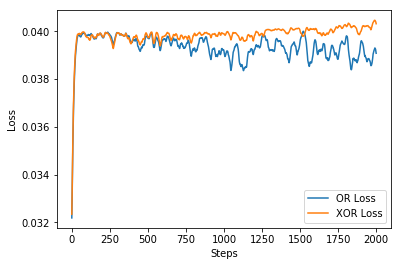

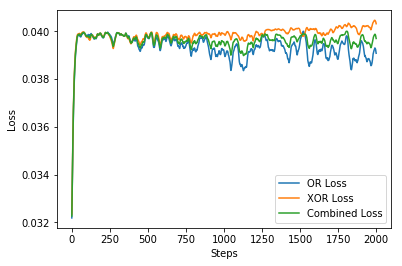

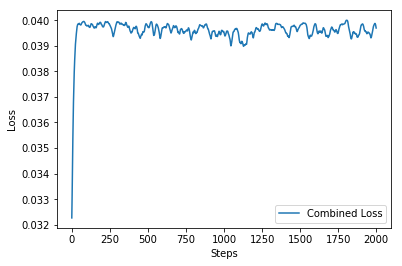

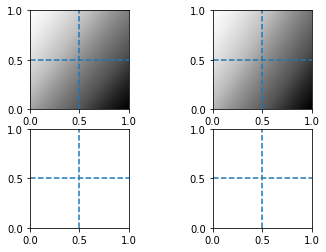

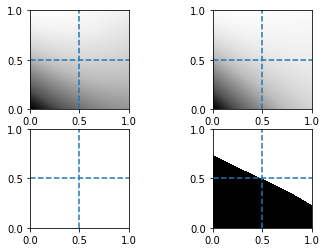

[4] False None
Average loss or before training:  0.6434262931346894
Average loss xor before training:  0.6465448856353759
Average loss before training:  0.6449855893850327
Average loss or before xor training:  0.6434262931346894
Average loss xor before xor training:  0.6465448856353759
Average loss before xor training:  0.6449855893850327
Average loss or:  0.7815250039100647
Average loss xor:  0.80622318983078
Average loss:  0.7938740968704223
Median loss:  0.8001923739910126
Max loss:  0.8052501261234284
Min loss:  0.7667975902557373
Average change:  0.14888850748538962
[0.8106764554977417, 0.7941615581512451, 0.8271913528442383, 3, [4], False, None]


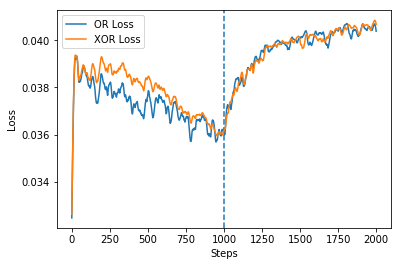

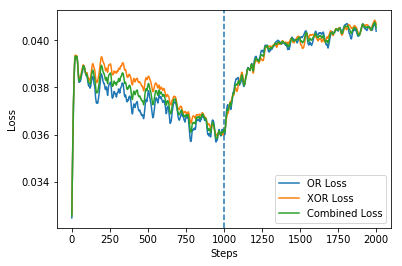

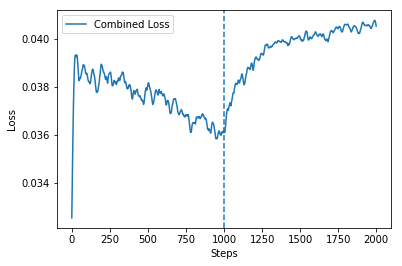

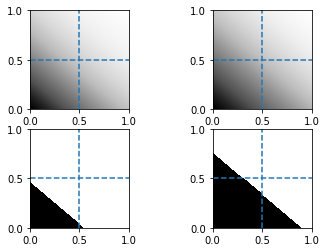

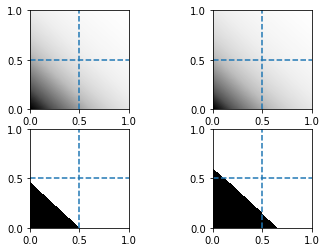

[4] True None
Average loss or before training:  0.6434262931346894
Average loss xor before training:  0.6465448856353759
Average loss before training:  0.6449855893850327
Average loss or before xor training:  0.7247338771820069
Average loss xor before xor training:  0.7234294295310975
Average loss before xor training:  0.7240816533565522
Average loss or:  0.8078700542449951
Average loss xor:  0.8136277914047241
Average loss:  0.8107489228248597
Median loss:  0.8152554988861084
Max loss:  0.817070996761322
Min loss:  0.792935049533844
Average change:  0.0866672694683075
[0.8253097832202911, 0.8205142021179199, 0.8301053643226624, 4, [4], True, None]


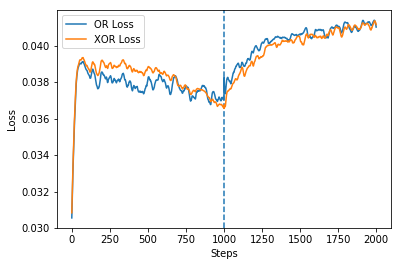

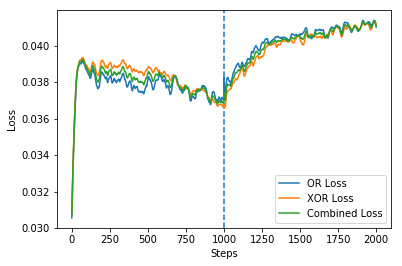

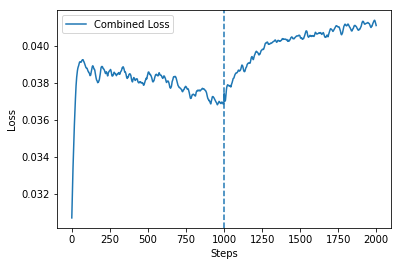

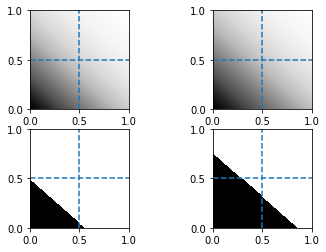

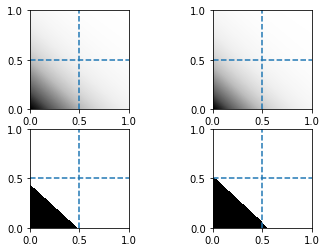

[3] True [1]
Average loss or before training:  0.6030644595623016
Average loss xor before training:  0.6089354991912842
Average loss before training:  0.605999979376793
Average loss or before xor training:  0.7407933592796325
Average loss xor before xor training:  0.7336804270744324
Average loss before xor training:  0.7372368931770324
Average loss or:  0.8203633904457093
Average loss xor:  0.8231011033058167
Average loss:  0.821732246875763
Median loss:  0.8237823247909546
Max loss:  0.8299640417098999
Min loss:  0.8066283464431763
Average change:  0.08449535369873051
[0.8371971547603607, 0.8293368816375732, 0.8450574278831482, 4, [3], True, [1]]


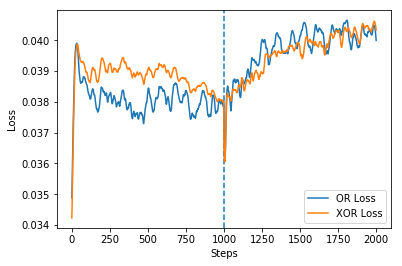

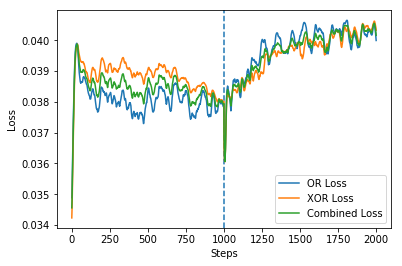

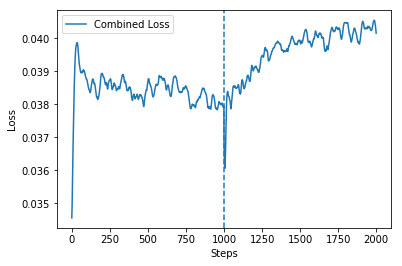

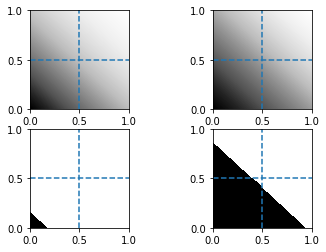

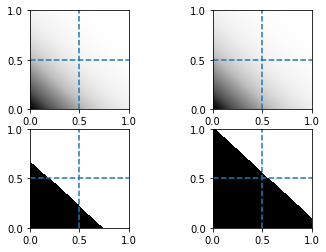

[2] True [2]
Average loss or before training:  0.6956098437309265
Average loss xor before training:  0.6823360204696656
Average loss before training:  0.688972932100296
Average loss or before xor training:  0.7573045372962952
Average loss xor before xor training:  0.7603026866912842
Average loss before xor training:  0.7588036119937898
Average loss or:  0.7998085498809815
Average loss xor:  0.8064604878425599
Average loss:  0.8031345188617707
Median loss:  0.8122722148895264
Max loss:  0.8227425754070282
Min loss:  0.7739489912986756
Average change:  0.04433090686798091
[0.8331093490123749, 0.8390246629714966, 0.8271940350532532, 2, [2], True, [2]]


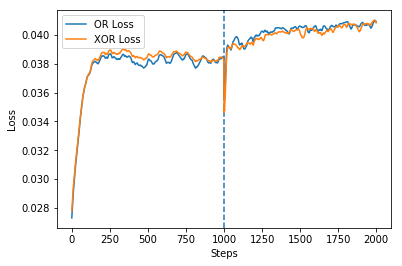

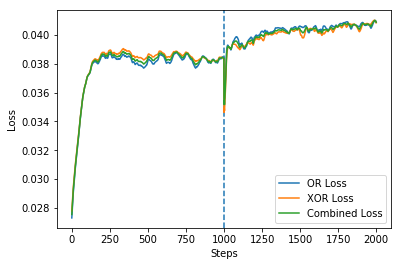

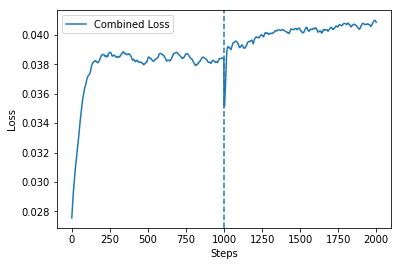

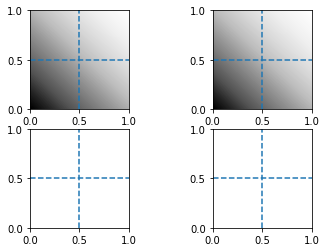

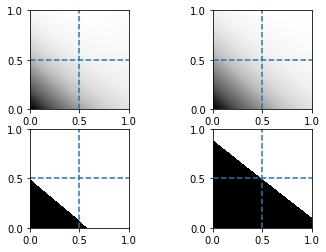

[1] True [3]
Average loss or before training:  0.5455200880765915
Average loss xor before training:  0.5551641911268235
Average loss before training:  0.5503421396017074
Average loss or before xor training:  0.7686247825622559
Average loss xor before xor training:  0.7662333250045776
Average loss before xor training:  0.7674290537834167
Average loss or:  0.8180262565612793
Average loss xor:  0.8167558789253235
Average loss:  0.8173910677433014
Median loss:  0.8191175699234009
Max loss:  0.8257257878780365
Min loss:  0.8091408550739289
Average change:  0.049962013959884644
[0.8309721648693085, 0.8346956968307495, 0.8272486329078674, 3, [1], True, [3]]


In [ ]:
device= 'cpu'

x = np.linspace(0, 1.0, 2)
y = np.linspace(0, 1.0, 2)

Xs_OR = []
Ys_OR = []
Xs_XOR = []
Ys_XOR = []
for i in y:
    for j in x:
        Xs_OR.append([i,j,0])
        Xs_XOR.append([i, j, 1])
        Ys_OR.append([int(i>0.5 or j>0.5)])
        Ys_XOR.append([int(i>0.5 and not j>0.5) or int(not i>0.5 and j>0.5)])
        
Xs_OR = torch.tensor(Xs_OR, dtype=torch.float).to(device)
Xs_XOR = torch.tensor(Xs_XOR, dtype=torch.float).to(device)
Ys_OR = torch.tensor(Ys_XOR, dtype=torch.float).to(device)
Ys_XOR = torch.tensor(Ys_OR, dtype=torch.float).to(device)

def xor_experiments(initial_capacity, train_or, capacity, non_linearity, OR_distribution, XOR_distribution, threshold, keep_lr):
    x = np.linspace(0, 1.0, 100)
    y = np.linspace(0, 1.0, 100)
    
    OR_mat = np.zeros((100,100))
    XOR_mat = np.zeros((100,100))
    
    tmp_pre_OR_mat = np.zeros((100,100))
    tmp_pre_XOR_mat = np.zeros((100,100))
    
    pre_OR_mat = np.zeros((100,100))
    pre_XOR_mat = np.zeros((100,100))
    
    lowest_loss = 0
    lowest_settings = []
    
    pre_pre_loss_or = []
    pre_pre_loss_xor = []
    
    pre_loss_or = []
    pre_loss_xor = []
    
    losses_or = []
    losses_xor = []
        
    iterations = 1000
    
    all_losses_OR = np.zeros(iterations*2)
    all_losses_XOR = np.zeros(iterations*2)
    
    for seed in range(5):
        # Set seeds
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Initialisation network
        network = DQN(3, initial_capacity.copy(), 1, non_linearity).to(device)
        optimizer = optim.Adam(network.parameters(), amsgrad=True,lr=0.01)
        criterion = nn.MSELoss()
        
#         prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
#         Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
        prediction = network(Xs_OR)
        OR_loss = 1.0/(1.0+criterion(prediction, Ys_OR))
            
#         prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
#         Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
        prediction = network(Xs_XOR)
        XOR_loss = 1.0/(1.0+criterion(prediction, Ys_XOR))
            
        pre_pre_loss_or.append(OR_loss.item())
        pre_pre_loss_xor.append(XOR_loss.item())
        
        global_i = 0
        final_or_i = 0
        OR_iterations = 0
        if train_or:
            OR_iterations = iterations
            for i in range(OR_iterations):
                optimizer.zero_grad()
                
                # Uniform 0.5, Naive 1.0, Zaremba 0.9
                Xs, Ys = generate_both(1, OR_distribution)
                    
                Xs = torch.tensor(Xs).to(device)
                Ys = torch.tensor(Ys, dtype=torch.float).to(device)

                prediction = network(Xs)
                loss = criterion(prediction, Ys)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    # Evaluation OR
#                     prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
#                     Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
                    prediction = network(Xs_OR)
                    OR_loss = 1.0/(1.0+criterion(prediction, Ys_OR))
                    
                    all_losses_OR[global_i] += OR_loss
                    
                    # Evaluation XOR
#                     prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
#                     Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
                    prediction = network(Xs_XOR)
                    XOR_loss = 1.0/(1.0+criterion(prediction, Ys_XOR))
                    
                    all_losses_XOR[global_i] += XOR_loss
                
                global_i += 1

                if OR_loss>threshold:
                    #Fill rest of array with last OR and XOR score
                    for j in range(OR_iterations - global_i):
                        all_losses_OR[j + global_i] += OR_loss
                        all_losses_XOR[j + global_i] += XOR_loss
                    global_i += OR_iterations - global_i
                    break
            
        pre_loss_or.append(OR_loss.item())
        pre_loss_xor.append(XOR_loss.item())
        
        for idx_y, grid_point_y in enumerate(y):
            for idx_x, grid_point_x in enumerate(x):
                tmp_pre_OR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 0.0]).to(device)).item()
                tmp_pre_XOR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 1.0]).to(device)).item()
        
        if capacity is not None and train_or:
            if not keep_lr:
                network.increase_capacity(capacity)
                optimizer = optim.Adam(network.parameters(), amsgrad=True, lr=0.01)
            else:
                 network, optimizer = increase_capacity_keep_lr(network, capacity, optimizer, device)
            
        XOR_iterations = iterations
        if not train_or:
            XOR_iterations = iterations*2
        
        for i in range(XOR_iterations):
            optimizer.zero_grad()
            
            # Uniform 0.5, Naive 1.0, Zaremba 0.1
            Xs, Ys = generate_both(1, XOR_distribution)
                
            Xs = torch.tensor(Xs).to(device)
            Ys = torch.tensor(Ys, dtype=torch.float).to(device)

            prediction = network(Xs)
            loss = criterion(prediction, Ys)

            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                # Evaluation OR
#                 prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
#                 Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
                prediction = network(Xs_OR)
                OR_loss = 1.0/(1.0+criterion(prediction, Ys_OR))
                    
                all_losses_OR[global_i] += OR_loss
                
                # Evaluation XOR
#                 prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
#                 Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
                prediction = network(Xs_XOR)
                XOR_loss = 1.0/(1.0+criterion(prediction, Ys_XOR))
                
                all_losses_XOR[global_i] += XOR_loss
            
            global_i += 1
            
            if XOR_loss>threshold:
                for j in range(XOR_iterations + OR_iterations - global_i):
                    all_losses_OR[j + global_i] += OR_loss
                    all_losses_XOR[j + global_i] += XOR_loss
                break
        
        average_loss = 0
        
        average_loss += OR_loss.item()
        losses_or.append(OR_loss.item())
        
        average_loss += XOR_loss.item()
        average_loss /= 2
        losses_xor.append(XOR_loss.item())
        
        if average_loss > lowest_loss:
            pre_OR_mat = tmp_pre_OR_mat
            pre_XOR_mat = tmp_pre_XOR_mat
            
            for idx_y, grid_point_y in enumerate(y):
                for idx_x, grid_point_x in enumerate(x):
                    OR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 0.0]).to(device)).item()
                    XOR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 1.0]).to(device)).item()
            lowest_loss = copy.copy(average_loss)
            lowest_settings = [average_loss, losses_or[-1], losses_xor[-1], seed, initial_capacity, train_or, capacity]
        
    plt.figure()
    if train_or:
        plt.axvline(x=OR_iterations, linestyle='dashed')
    plt.plot(all_losses_OR/100, label='OR Loss')
    plt.plot(all_losses_XOR/100, label='XOR Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    if train_or:
        plt.axvline(x=OR_iterations, linestyle='dashed')
    plt.plot(all_losses_OR/100, label='OR Loss')
    plt.plot(all_losses_XOR/100, label='XOR Loss')
    plt.plot((all_losses_OR+ all_losses_XOR)/200, label='Combined Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.figure()
    if train_or:
        plt.axvline(x=OR_iterations, linestyle='dashed')
    plt.plot((all_losses_OR+ all_losses_XOR)/200, label='Combined Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(pre_OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
    plt.subplot(2, 2, 2)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(pre_XOR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))

    plt.subplot(2, 2, 3)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(pre_OR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
    plt.subplot(2, 2, 4)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(pre_XOR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))

    plt.show()
    
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
    plt.subplot(2, 2, 2)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(XOR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))

    plt.subplot(2, 2, 3)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(OR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
    plt.subplot(2, 2, 4)
    plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
    plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
    plt.imshow(1.0 - np.flip(XOR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))

    plt.show()
    
    # Print statistics
    print(initial_capacity, train_or, capacity)
    
    print('Average loss or before training: ', np.average(pre_pre_loss_or))
    print('Average loss xor before training: ', np.average(pre_pre_loss_xor))
    print('Average loss before training: ', (np.average(pre_pre_loss_or) + np.average(pre_pre_loss_xor))/2)
    
    print('Average loss or before xor training: ', np.average(pre_loss_or))
    print('Average loss xor before xor training: ', np.average(pre_loss_xor))
    print('Average loss before xor training: ', (np.average(pre_loss_or) + np.average(pre_loss_xor))/2)
          
    print('Average loss or: ', np.average(losses_or))
    print('Average loss xor: ', np.average(losses_xor))
    print('Average loss: ', (np.average(losses_or) +  np.average(losses_xor))/2)
    print('Median loss: ', (np.median(losses_or) +  np.average(losses_xor))/2)
    print('Max loss: ', (np.amax(losses_or) +  np.average(losses_xor))/2)
    print('Min loss: ', (np.amin(losses_or) +  np.average(losses_xor))/2)
    print('Average change: ', (np.average(losses_or) +  np.average(losses_xor))/2 - (np.average(pre_loss_or) + np.average(pre_loss_xor))/2)
    print(lowest_settings)

non_linearity = torch.sigmoid
OR_p = 0.9
XOR_p = 0.1
threshold = 0.99
keep_lr = False

xor_experiments([1],False,None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([1], True, None,non_linearity,OR_p, XOR_p, threshold, keep_lr)

xor_experiments([2],False,None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([2], True, None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([1], True, [1],non_linearity,OR_p, XOR_p, threshold, keep_lr)

xor_experiments([3],False,None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([3], True, None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([2], True, [1],non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([1], True, [2],non_linearity,OR_p, XOR_p, threshold, keep_lr)

xor_experiments([4],False,None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([4], True, None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([3], True, [1],non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([2], True, [2],non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([1], True, [3],non_linearity,OR_p, XOR_p, threshold, keep_lr)

xor_experiments([5],False,None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([5], True, None,non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([4], True, [1],non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([3], True, [2],non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([2], True, [3],non_linearity,OR_p, XOR_p, threshold, keep_lr)
xor_experiments([1], True, [4],non_linearity,OR_p, XOR_p, threshold, keep_lr)

# 1.0 Loss Possible? Yes:)

In [41]:
network = DQN(3, [3], 1, F.relu)
criterion = nn.MSELoss()
# network.layers[0].weight.data = torch.tensor([[1.0,1.0,0.0],[1.0,1.0,0.0],[0.0,0.0,1.0]], dtype=torch.float)
# network.layers[1].weight.data = torch.tensor([[1.0,0.0,0.0],[0.0,1.0,0.0],[1.0,0.0,-1.0]], dtype=torch.float)
# network.layers[2].weight.data = torch.tensor([[-2.0,1.0,1.0]], dtype=torch.float)
# network.layers[0].bias.data = torch.tensor([-1.0,0.0,0.0], dtype=torch.float)
# network.layers[1].bias.data = torch.tensor([0.0,0.0,0.0], dtype=torch.float)
# network.layers[2].bias.data = torch.tensor([0.0], dtype=torch.float)

network.layers[0].weight.data = torch.tensor([[1.0,1.0,0.0],[1.0,1.0,0.0],[1.0,1.0,-1.0]], dtype=torch.float)
network.layers[1].weight.data = torch.tensor([[-2.0,1.0,1.0]], dtype=torch.float)
network.layers[0].bias.data = torch.tensor([-1.0,0.0,-1.0], dtype=torch.float)
network.layers[1].bias.data = torch.tensor([0.0], dtype=torch.float)

x = F.relu(network.layers[0](torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float)))
print(x)
x = F.relu(network.layers[1](x))
print(x)

prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
OR_loss = 1.0/(1.0+torch.sqrt(criterion(prediction, Ys)))
print(prediction)

prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
XOR_loss = 1.0/(1.0+torch.sqrt(criterion(prediction, Ys)))
print(prediction)

print(OR_loss)
print(XOR_loss)

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 2., 0.]], grad_fn=<ReluBackward0>)
tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<ReluBackward0>)
tensor([[0.],
        [1.],
        [1.],
        [1.]], grad_fn=<AddmmBackward>)
tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<AddmmBackward>)
tensor(1., grad_fn=<MulBackward0>)
tensor(1., grad_fn=<MulBackward0>)


# 1.0 possible by training?

In [47]:
# random.seed(421)
# np.random.seed(421)
# torch.manual_seed(421)

# network = DQN(3, [3,3], 1, F.sigmoid)
# # network.layers[0].weight.data = torch.empty(2,2).uniform_(-1, 1)
# # network.layers[1].weight.data = torch.empty(1,2).uniform_(-1, 1)
# # network.layers[0].bias.data = torch.empty(2).uniform_(-1, 1)
# # network.layers[1].bias.data = torch.empty(1).uniform_(-1, 1)

# optimizer = optim.Adam(network.parameters(),lr=0.01,amsgrad=True)
criterion = nn.MSELoss()
        


capacities = [[2],[3]]
iterations = 10000
train_or = True
OR_distribution = 0.9
XOR_distribution = 0.1

for cap in capacities:
    # Initialisation network
    network = DQN(3, cap, 1, F.relu)
    optimizer = optim.Adam(network.parameters(), amsgrad=True)
    criterion = nn.MSELoss()
    best = 0
    best_pred_OR = []
    best_pred_XOR = []
    OR_iterations = 0
    if train_or:
        OR_iterations = iterations
        for i in range(OR_iterations):
            optimizer.zero_grad()

            # Uniform 0.5, Naive 1.0, Zaremba 0.9
            Xs, Ys = generate_both(25, OR_distribution)

            Xs = torch.tensor(Xs)
            Ys = torch.tensor(Ys, dtype=torch.float)

            prediction = network(Xs)
            loss = criterion(prediction, Ys)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # Evaluation OR
                OR_prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
                Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
                OR_loss = 1.0/(1.0+criterion(OR_prediction, Ys))

                

                # Evaluation XOR
                XOR_prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
                Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
                XOR_loss = 1.0/(1.0+criterion(XOR_prediction, Ys))
            
            if((OR_loss+XOR_loss)/2 > best):
                best = (OR_loss+XOR_loss)/2
                best_pred_OR = OR_prediction
                best_pred_XOR = XOR_prediction

            if OR_loss>threshold:

                break



#     network.increase_capacity([1]*len(cap))
#     optimizer = optim.Adam(network.parameters(), amsgrad=True)


    XOR_iterations = iterations
    if not train_or:
        XOR_iterations = iterations*2

    for i in range(XOR_iterations):
        optimizer.zero_grad()

        # Uniform 0.5, Naive 1.0, Zaremba 0.1
        Xs, Ys = generate_both(25, XOR_distribution)

        Xs = torch.tensor(Xs)
        Ys = torch.tensor(Ys, dtype=torch.float)

        prediction = network(Xs)
        loss = criterion(prediction, Ys)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Evaluation OR
            OR_prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)
            OR_loss = 1.0/(1.0+criterion(OR_prediction, Ys))

            # Evaluation XOR
            XOR_prediction = network(torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float))
            Ys = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)
            XOR_loss = 1.0/(1.0+criterion(XOR_prediction, Ys))
        
        if((OR_loss+XOR_loss)/2 > best):
            best = (OR_loss+XOR_loss)/2
            best_pred_OR = OR_prediction
            best_pred_XOR = XOR_prediction

        if XOR_loss>threshold:
            break
    
    
    print(cap, OR_loss, XOR_loss,(OR_loss+XOR_loss)/2)
    print(OR_prediction, XOR_prediction)
    print(best)
    print(best_pred_OR)
    print(best_pred_XOR)
    print('-----------')

[2] tensor(0.9338) tensor(0.8804) tensor(0.9071)
tensor([[-0.5153],
        [ 0.9992],
        [ 0.9992],
        [ 0.8658]]) tensor([[-0.5178],
        [ 0.9768],
        [ 0.9832],
        [-0.5238]])
tensor(0.9353)
tensor([[-0.5070],
        [ 0.9999],
        [ 0.9999],
        [ 0.8433]])
tensor([[-0.4768],
        [ 0.8689],
        [ 0.8915],
        [-0.1239]])
-----------
[3] tensor(0.8739) tensor(0.7971) tensor(0.8355)
tensor([[0.6437],
        [0.7389],
        [0.7400],
        [0.8353]]) tensor([[0.4049],
        [0.5002],
        [0.5013],
        [0.5966]])
tensor(0.8466)
tensor([[0.4477],
        [0.7524],
        [0.7923],
        [1.0970]])
tensor([[0.2257],
        [0.5304],
        [0.5703],
        [0.8750]])
-----------


# What loss to use

In [82]:
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()


Xs = [[0,1,1,0],[0,0,0,0],[0,1,0,0],[1,0,0,0],[1,1,0,0],[0,0.5,0.5,0],[0.5,0.5,0.5,0.5],[-1,2,2,-1],[0,1,1,1],[0,1,1,0.5]]

Ys_XOR = torch.tensor([0,1,1,0],dtype=torch.float)
Ys_OR = torch.tensor([0,1,1,1],dtype=torch.float)
for x in Xs:
    x = torch.tensor(x,dtype=torch.float)
    print(x.data)
    print(1.0/(1.0+criterion1(x,Ys_OR).item()),1.0/(1.0+torch.sqrt(criterion2(x,Ys_OR)).item()))
    print(1.0/(1.0+criterion1(x,Ys_XOR).item()),1.0/(1.0+torch.sqrt(criterion2(x,Ys_XOR)).item()))
    print('---------------------------------')

tensor([0., 1., 1., 0.])
0.8 0.6666666666666666
1.0 1.0
---------------------------------
tensor([0., 0., 0., 0.])
0.5714285714285714 0.5358983893261735
0.6666666666666666 0.5857864417795234
---------------------------------
tensor([0., 1., 0., 0.])
0.6666666666666666 0.5857864417795234
0.8 0.6666666666666666
---------------------------------
tensor([1., 0., 0., 0.])
0.5 0.5
0.5714285714285714 0.5358983893261735
---------------------------------
tensor([1., 1., 0., 0.])
0.5714285714285714 0.5358983893261735
0.6666666666666666 0.5857864417795234
---------------------------------
tensor([0.0000, 0.5000, 0.5000, 0.0000])
0.7272727272727273 0.6202040943146127
0.8888888888888888 0.7387961283389092
---------------------------------
tensor([0.5000, 0.5000, 0.5000, 0.5000])
0.8 0.6666666666666666
0.8 0.6666666666666666
---------------------------------
tensor([-1.,  2.,  2., -1.])
0.36363636363636365 0.4305008808257422
0.5 0.5
---------------------------------
tensor([0., 1., 1., 1.])
1.0 1.0


# Cartesian Representation

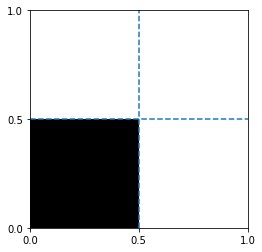

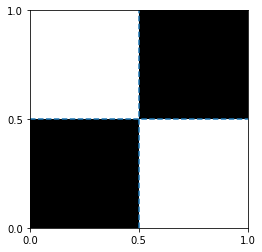

In [75]:
x = np.linspace(0, 1.0, 100)
y = np.linspace(0, 1.0, 100)

OR_mat = np.zeros((100,100))
OR_mat[50:,:50] = 1.0

XOR_mat = np.zeros((100,100))
XOR_mat[50:,:50] = 1.0
XOR_mat[:50,50:] = 1.0

# plt.axis('off')
        
plt.figure()
plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
plt.xticks(np.arange(min(x), max(x)+1, 0.5))
plt.yticks(np.arange(min(y), max(y)+1, 0.5))
plt.imshow(OR_mat, interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
plt.figure()
plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
plt.xticks(np.arange(min(x), max(x)+1, 0.5))
plt.yticks(np.arange(min(y), max(y)+1, 0.5))
plt.imshow(XOR_mat, interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))

KruskalResult(statistic=4.999999999999996, pvalue=0.025347318677468363)

# Animation

In [165]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Joe Harrison'), bitrate=1800)

/home/joe/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.5343065313124532
1 0.55365253673515


/home/joe/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


2 0.5650316177209039
3 0.5765849188126168
4 0.6010322704712854
5 0.5907165496316281
6 0.6074982063517778
7 0.6314380437106671
8 0.6238854424674919
9 0.6483894837889836
10 0.6599798590130916
11 0.6719599839503881
12 0.6773382230357192
13 0.6891945952672942
14 0.7020633815263211
15 0.718717579649789
16 0.7303283634105804
17 0.7414253496767415
18 0.7509659268312929
19 0.7565511892146599
20 0.7691107251675947
21 0.7777246795513796
22 0.7841825356379661
23 0.7935331921480152
24 0.8004422915112511
25 0.8064084735582765
26 0.8065172504172935
27 0.8126848803116278
28 0.8228602313722031
29 0.828761972778333
30 0.8241413875754856
31 0.8206336546079005
32 0.8357778245496923
33 0.839408913034989
34 0.8285077669442644
35 0.8233852333695575
36 0.8346713341723885
37 0.8332991324328816
38 0.8161420873551449
39 0.8483780320199041
40 0.8281059806034083
41 0.8274982457443076
42 0.8275476546223006
43 0.8409846857993691
44 0.840574868750799
45 0.8326769868082426
46 0.8224438341380045
47 0.8294872313846893


KeyboardInterrupt: 

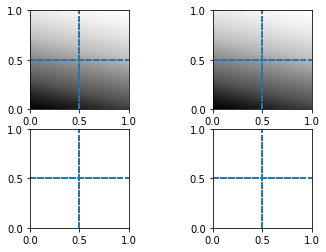

In [185]:
fig = plt.figure()

with writer.saving(fig, 'xorthresh.mp4' ,100):
    random.seed(13)
    np.random.seed(13)
    torch.manual_seed(13)
    
    x = np.linspace(0, 1.0, 100)
    y = np.linspace(0, 1.0, 100)
    
    network = DQN(3, [3], 1, F.sigmoid)
    optimizer = optim.Adam(network.parameters(), amsgrad=True, lr=0.01)
    criterion = nn.MSELoss()
    
    for i in range(1000):
        
        optimizer.zero_grad()

        Xs, Ys = generate_both(25,0.9)
                    
        Xs = torch.tensor(Xs)
        Ys = torch.tensor(Ys, dtype=torch.float)

        prediction = network(Xs)
        loss = criterion(prediction, Ys)

        loss.backward()
        optimizer.step()
        
        print(i, 1.0/(1.0+loss.item()))

        OR_mat = np.zeros((100,100))
        XOR_mat = np.zeros((100,100))

        for idx_y, grid_point_y in enumerate(y):
            for idx_x, grid_point_x in enumerate(x):
                OR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 0.0])).item()
                XOR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 1.0])).item()

        
        
        plt.subplot(2, 2, 1)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        plt.subplot(2, 2, 2)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(XOR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        
        plt.subplot(2, 2, 3)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(OR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        plt.subplot(2, 2, 4)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(XOR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        
        writer.grab_frame()
        
    network.increase_capacity([1])
    optimizer = optim.Adam(network.parameters(), amsgrad=True, lr=0.01)
    
    for i in range(1000):
       
        optimizer.zero_grad()

        Xs, Ys = generate_both(25,0.1)
                    
        Xs = torch.tensor(Xs)
        Ys = torch.tensor(Ys, dtype=torch.float)

        prediction = network(Xs)
        loss = criterion(prediction, Ys)

        loss.backward()
        optimizer.step()
        
        print(i, 1.0/(1.0+loss.item()))

        OR_mat = np.zeros((100,100))
        XOR_mat = np.zeros((100,100))

        for idx_y, grid_point_y in enumerate(y):
            for idx_x, grid_point_x in enumerate(x):
                OR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 0.0])).item()
                XOR_mat[idx_y, idx_x] = network(torch.tensor([grid_point_x, grid_point_y, 1.0])).item()

        
        plt.subplot(2, 2, 1)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        plt.subplot(2, 2, 2)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(XOR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        
        plt.subplot(2, 2, 3)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(OR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        plt.subplot(2, 2, 4)
        plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
        plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
        plt.xticks(np.arange(min(x), max(x)+1, 0.5))
        plt.yticks(np.arange(min(y), max(y)+1, 0.5))
        plt.imshow(1.0 - np.flip(XOR_mat > 0.5,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
        

        writer.grab_frame()

[[0 1]
 [2 3]]
[[2 3]
 [0 1]]


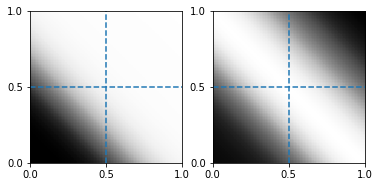

In [182]:
plt.subplot(1, 2, 1)
plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
plt.xticks(np.arange(min(x), max(x)+1, 0.5))
plt.yticks(np.arange(min(y), max(y)+1, 0.5))
plt.imshow(1.0-np.flip(OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
plt.subplot(1, 2, 2)
plt.axvline(x=0.5, color='#1f77b4', linestyle='dashed')
plt.axhline(y=0.5, color='#1f77b4', linestyle='dashed')
plt.xticks(np.arange(min(x), max(x)+1, 0.5))
plt.yticks(np.arange(min(y), max(y)+1, 0.5))
plt.imshow(1.0 - np.flip(XOR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))

OR_mat[0,0]

a=np.array([[0,1],[2,3]])
print(a)
print(np.flip(a,0))

# Weight Change

In [56]:
def weight_change(initial_capacity, train_or, capacity, non_linearity):
    common_weight = []
    new_weight = []
    total_weight = []
    common_bias = []
    new_bias = []
    total_bias = []
    
    for idx in range(len(initial_capacity)+1):
        common_weight.append([])
        new_weight.append([])
        total_weight.append([])
        common_bias.append([])
        new_bias.append([])
        total_bias.append([])
    
    for seed in range(100):  
        # Set seeds
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Initialisation network
        network = DQN(3, initial_capacity.copy(), 1, non_linearity).to(device)
        optimizer = optim.Adam(network.parameters(), amsgrad=True)
        criterion = nn.MSELoss()
        
        if train_or:
            for i in range(1000):
                optimizer.zero_grad()

                Xs, Ys = generate_both(25,0.1)
                    
                Xs = torch.tensor(Xs, device=device)
                Ys = torch.tensor(Ys, dtype=torch.float, device=device)

                prediction = network(Xs)
                loss = criterion(prediction, Ys)

                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    # Evaluation
                    prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float, device=device))
                    Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float, device=device)
                    loss = 1.0/(1.0+criterion(prediction, Ys))

                if loss>0.95:
                    break
                    
                network_before_increase = copy.deepcopy(network)
        
        if capacity is not None:
            network, optimizer = increase_capacity_keep_lr(network, capacity, optimizer, device)
            
        network_after_increase = copy.deepcopy(network)
        
        iters = 1000
#         if not train_or:
#             (155) * 1000
            
        for i in range(iters):
            optimizer.zero_grad()
            
            # Uniform syllabus 20% of the time
            Xs, Ys = generate_both(25,0.9)
                
            Xs = torch.tensor(Xs, device=device)
            Ys = torch.tensor(Ys, dtype=torch.float, device=device)

            prediction = network(Xs)
            loss = criterion(prediction, Ys)

            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                # Evaluation
                prediction = network(torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float, device=device))
                Ys = torch.tensor([[0],[1],[1],[1]], dtype=torch.float, device=device)
                loss = 1.0/(1.0+criterion(prediction, Ys))

            if loss>0.95:
                break
        
        for idx in range(len(initial_capacity) + 1):
            if idx==0: 
                common_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight[0:initial_capacity[0],:] - network_after_increase.layers[idx].weight[0:initial_capacity[0],:])).item())
                new_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight[initial_capacity[0]:,:] - network_after_increase.layers[idx].weight[initial_capacity[0]:,:])).item())
                
            elif idx<len(initial_capacity):
                common_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight[0:initial_capacity[idx],0:initial_capacity[idx - 1] ] - network_after_increase.layers[idx].weight[0:initial_capacity[idx],0:initial_capacity[idx-1]])).item())
                new_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight[initial_capacity[idx]:,initial_capacity[idx - 1]:] - network_after_increase.layers[idx].weight[initial_capacity[idx]:,initial_capacity[idx-1]:])).item())
            else:
                common_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight[:,0:initial_capacity[idx - 1] ] - network_after_increase.layers[idx].weight[:,0:initial_capacity[idx-1]])).item())
                new_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight[:,initial_capacity[idx - 1]: ] - network_after_increase.layers[idx].weight[:,initial_capacity[idx-1]:])).item())
            
            total_weight[idx].append(torch.mean(torch.abs(network.layers[idx].weight - network_after_increase.layers[idx].weight)).item())
            
            if idx<len(initial_capacity):
                common_bias[idx].append(torch.mean(torch.abs(network.layers[idx].bias[:initial_capacity[idx]] - network_after_increase.layers[idx].bias[:initial_capacity[idx]])).item())
                new_bias[idx].append(torch.mean(torch.abs(network.layers[idx].bias[initial_capacity[idx]:] - network_after_increase.layers[idx].bias[initial_capacity[idx]:])).item())
            else:
                common_bias[idx].append(torch.mean(torch.abs(network.layers[idx].bias - network_after_increase.layers[idx].bias)).item())
                new_bias[idx].append(torch.mean(torch.abs(network.layers[idx].bias - network_after_increase.layers[idx].bias)).item())
            total_bias[idx].append(torch.mean(torch.abs(network.layers[idx].bias - network_after_increase.layers[idx].bias)).item())
            
    for idx in range(len(initial_capacity)+1):
        print('Layer ', idx)
        print('Common Weights ', np.average(np.array(common_weight[idx])))
        print('New Weights', np.average(np.array(new_weight[idx])))
        print('Total Weights', np.average(np.array(total_weight[idx])))
        print('Common Bias', np.average(np.array(common_bias[idx])))
        print('New Bias', np.average(np.array(new_bias[idx])))
        print('Total Bias', np.average(np.array(total_bias[idx])))
        
initial_capacity = [4, 2]
capacity = None
train_or = True
non_linearity = F.elu
weight_change(initial_capacity, train_or, capacity, non_linearity)
print('----')
non_linearity = F.elu
initial_capacity = [1, 1]
capacity = [3, 1]
train_or = True
weight_change(initial_capacity, train_or, capacity, non_linearity)   

Layer  0
Common Weights  0.1325120122922817
New Weights nan
Total Weights 0.1325120122922817
Common Bias 0.11899544576182962
New Bias nan
Total Bias 0.11899544576182962
Layer  1
Common Weights  0.09948775259195827
New Weights nan
Total Weights 0.09948775259195827
Common Bias 0.05169446752406657
New Bias nan
Total Bias 0.05169446752406657
Layer  2
Common Weights  0.0789904136955738
New Weights nan
Total Weights 0.0789904136955738
Common Bias 0.03740000854479149
New Bias 0.03740000854479149
Total Bias 0.03740000854479149
----
Layer  0
Common Weights  0.09778607580810786
New Weights 0.3256713739037514
Total Weights 0.2687000571191311
Common Bias 0.07550684549380093
New Bias 0.2097055184841156
Total Bias 0.17615584552288055
Layer  1
Common Weights  0.06564888074994087
New Weights 0.3036353275179863
Total Weights 0.24524433545768262
Common Bias 0.03238602567464113
New Bias 0.12760944755747913
Total Bias 0.07999773657880724
Layer  2
Common Weights  0.0603395657800138
New Weights 0.2521250639

In [158]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

EPOCHS_TO_TRAIN = 1500



net = DQN(3, [2], 1, F.elu)

inputs = torch.tensor([[0, 0, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 0, 0],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 0]],dtype=torch.float)

targets = torch.tensor([[0],
    [1],
    [1],
    [0],
    [0],
    [1],
    [1],
    [1]],dtype=torch.float)


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), amsgrad=True)

print("Training loop:")
for idx in range(0, EPOCHS_TO_TRAIN):
#     for i in range(8):
    optimizer.zero_grad()   # zero the gradient buffers
    x = inputs
    y = targets
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
    if idx%1000==0:
        net, optimizer = increase_capacity_keep_lr(net, [1], optimizer, device='cpu')
        
    if idx%100==0:
        print(loss)

output = net(inputs)
print(output)
print(1.0/(1.0+criterion(output, targets)))

Training loop:
tensor(0.2731, grad_fn=<MseLossBackward>)
tensor(0.2407, grad_fn=<MseLossBackward>)
tensor(0.2236, grad_fn=<MseLossBackward>)
tensor(0.2030, grad_fn=<MseLossBackward>)
tensor(0.1941, grad_fn=<MseLossBackward>)
tensor(0.1909, grad_fn=<MseLossBackward>)
tensor(0.1896, grad_fn=<MseLossBackward>)
tensor(0.1889, grad_fn=<MseLossBackward>)
tensor(0.1885, grad_fn=<MseLossBackward>)
tensor(0.1882, grad_fn=<MseLossBackward>)
tensor(0.1879, grad_fn=<MseLossBackward>)
tensor(0.1819, grad_fn=<MseLossBackward>)
tensor(0.1562, grad_fn=<MseLossBackward>)
tensor(0.1286, grad_fn=<MseLossBackward>)
tensor(0.1056, grad_fn=<MseLossBackward>)
tensor([[0.1408],
        [0.5963],
        [0.6287],
        [0.5939],
        [0.0408],
        [0.9376],
        [0.9466],
        [1.0566]], grad_fn=<AddmmBackward>)
tensor(0.9211, grad_fn=<MulBackward0>)


In [145]:
random.randint(0,7)

1

In [14]:
random.randint(0,3)

0

In [29]:
x = np.linspace(0, 1.0, 2)

In [30]:
x

array([0., 1.])